## Challenge context
https://challengedata.ens.fr/participants/challenges/15/

Well-being at work is characterized by the way employees express their satisfaction with respect to their thermal environment, air quality of their workplace or environmental noise during work days. This subjective perception of the environmental conditions, such as feeling too warm or too cold for instance, has a tremendous impact on the health, the productivity and the well-being at work of each individual. Designing a data driven algorithm which manages to predict individuals' comfort with respect to their workplace environment is pivotal to providing adapted tunings of building management systems (such as the set points of heating, ventilating, and air conditioning systems) so as to ensure and monitor the best comfort in the building.

## Data Exploration

In [113]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from mlxtend.plotting import category_scatter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from vecstack import stacking
import xgboost as xgb
import seaborn as sns

In [62]:
data1 = pd.read_csv('x_train.csv')
data2 = pd.read_csv('y_train.csv')
data_test=pd.read_csv('x_test.csv')

#### We merge all columns of features and target in order to explore and visualize them.

In [135]:
data_glob=data1.copy()
data_glob['Score']=data2['Score']

In [175]:
# convert the type of variable 'Date' into a Date.
data_glob['Date']= pd.to_datetime(data_glob['Date'])
data_glob.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
ID             8000 non-null int64
Date           8000 non-null datetime64[ns]
Temperature    8000 non-null float64
Humidity       8000 non-null float64
Humex          8000 non-null float64
CO2            8000 non-null float64
Bright         8000 non-null float64
Score          8000 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 500.1 KB


#### The method .info() give us the number non-null entries in all columns, our train dataset consists of 8 columns:
1. ID: integer, uniquely identifies each observation,
2. String: defines date under format yyyy-mm-­d hh:mm:ss,
3. Temperature: real number, temperature inside the room,
4. Humidity: real number, humidity of ambient air in the room,
5. Humex: real number, indicator of air quality in the room,
6. CO2: Integer, CO2 level in the room, in ppm (parts per million),
7. Bright: Integer, characterizes the brightness of the room,
8. Score: The classes are {1,2,3,4,5}, 5 being the optimal comfort and 1 the worst.

In [5]:
data_glob.describe()

,ID,Temperature,Humidity,Humex,CO2,Bright,Score
count,8000.00000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,3999.50000,22.94535,33.790750,22.668762,586.471000,41.596375,2.930125
std,2309.54541,1.62307,8.241068,2.578996,202.641522,76.855898,0.893780
min,0.00000,17.90000,16.000000,15.500000,361.000000,1.000000,1.000000
25%,1999.75000,22.10000,27.000000,21.100000,452.000000,1.000000,2.000000
50%,3999.50000,23.20000,33.000000,22.800000,493.000000,1.000000,3.000000
75%,5999.25000,24.10000,41.000000,24.300000,693.250000,58.000000,4.000000
max,7999.00000,28.30000,58.000000,32.100000,2168.000000,882.000000,5.000000


#### The describe() method returns basic statistical values (mean, std, quantiles).
<p> It seems that there is no ouliers for all variables, a further study for them will be held, for the CO2 the maximun value is 2168 ppm which is considered as dangerous level. </p>

## Data Visualisation

<p> Le'ts see the distribution of our target variable score. </p>

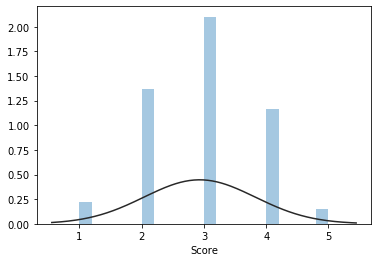

In [7]:
import seaborn as sns
from scipy.stats import norm
ax = sns.distplot(data_glob['Score'], fit=norm, kde=False)

The Score variable has a **Normal Distribution**. 

We tried first to plot just **Score** in function of **physical variables** (Temperature, Humidity).

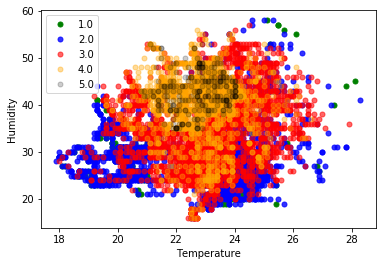

In [176]:
groups = data_glob.groupby('Score')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
alpha=1
colors=['green','blue','red','orange','black']
i=0
# We try to change the opacity for every color to better visualization.
for name, group in groups:
    ax.plot(group.Temperature, group.Humidity, marker='o', linestyle='', ms=5, label=name,color=colors[i],alpha=alpha)
    alpha=alpha-0.2
    i=i+1
ax.legend()
ax.set_xlabel('Temperature')
ax.set_ylabel('Humidity')
plt.show()

We played with opacity of colors to have a maximum understanding of different distributions of Scores, but still a little bit confusing, so we decided to choose Score=(1,5) respectively the worst and best cases.

In [177]:
nums=[1,5]
df=data_glob[data_glob['Score'].isin(nums)].reset_index()

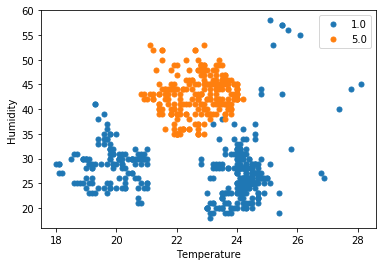

In [178]:
groups = df.groupby('Score')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.Temperature, group.Humidity, marker='o', linestyle='', ms=5, label=name)
ax.legend()
ax.set_xlabel('Temperature')
ax.set_ylabel('Humidity')
plt.show()

In [184]:
print(df.groupby('Score').agg({'Temperature': ["min", "max"]}).reset_index())
print(df.groupby('Score').agg({'Humidity': ["min", "max"]}).reset_index())

  Score Temperature      
                min   max
0   1.0        18.0  28.1
1   5.0        20.8  24.2
  Score Humidity      
             min   max
0   1.0     18.0  58.0
1   5.0     35.0  53.0


We can see that the best case (orange color) corresponds to a range of **(20.8 24.2)** of Temperature, and **(35 53)** of Humidity
, we do the same thing to [Humex, CO2] that represent the quality of air.

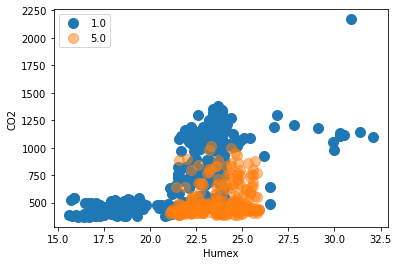

In [185]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
alpha=1
for name, group in groups:
    ax.plot(group.Humex, group.CO2, marker='o', linestyle='', ms=10, label=name,alpha=alpha)
    alpha=alpha-0.5
ax.legend()
ax.set_xlabel('Humex')
ax.set_ylabel('CO2')
plt.show()

In [186]:
print(df.groupby('Score').agg({'Humex': ["min", "max"]}).reset_index())
print(df.groupby('Score').agg({'CO2': ["min", "max"]}).reset_index())

  Score Humex      
          min   max
0   1.0  15.6  32.1
1   5.0  21.1  25.9
  Score    CO2        
           min     max
0   1.0  369.0  2168.0
1   5.0  382.0  1013.0


We can see that the best case of Score occurs in the range of Humex **(21.1 25.9)** and CO2 **(382 1013)**.

#### Now we will look at "Score" in function of each variable.
We compute the average of **Scores** for each value of the column, and we apply to it the function round().

In [187]:
def plot_moyenne(col):
    res=data_glob.groupby(data_glob[col].astype(int)).agg({'Score': ["mean", "std"]}).reset_index()
    plt.errorbar(x=res[(col,     '')], y=res[('Score','mean')], yerr=res[('Score',  'std')],marker='o')
    plt.xlabel(col)
    plt.ylabel('Score')


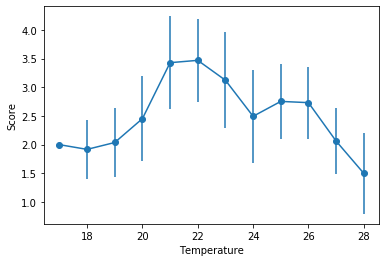

In [188]:
plot_moyenne('Temperature')

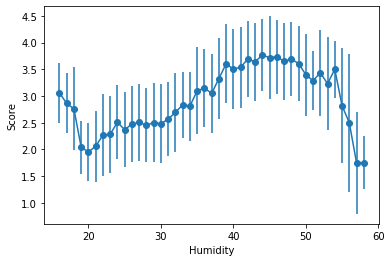

In [189]:
plot_moyenne('Humidity')

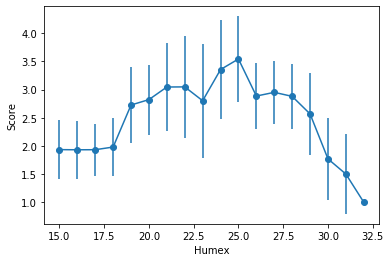

In [190]:
plot_moyenne('Humex')

From the previous graphs, we can pick the **optimum values** of each column, namely: **Temperature**, **Humidity** and **Humex** that leads to the best values of Score.

## Models
We will start by the basic model **decision tree** since we are dealing with a classification problem, the we will try other classifiers:  
1. RandomForestClassifier
2. GradientBoostingClassifier
3. HistGradientBoostingClassifier
4. XGBClassifier
5. ExtraTreesClassifier 

We note that the parameters of every model were tuned previously and the code will not be included in this notebook.

In [191]:
x=data1.iloc[:, 2: 7].values
y=data2.iloc[:, -1].values

We use the **cross validation** method to evaluate every model via **accuracy_score** metric.

In [193]:
def cross(model):
    cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    scores=cross_val_score(model, x, y, cv=cv)
    print("Accuracy of the "+str(type(model).__name__)+": %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [194]:
tree = DecisionTreeClassifier(class_weight="balanced",random_state=0)
forest = RandomForestClassifier(n_estimators=1000,max_depth=50, random_state=0,class_weight="balanced")
grad_boost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=0)
hist_boost = HistGradientBoostingClassifier(max_iter=10,max_depth=10,random_state=0)
xgb_model = xgb.XGBClassifier(objective="multi:softprob", learning_rate=0.05,max_depth=4,random_state=0)
extra_tree= ExtraTreesClassifier(n_estimators=300,max_depth=15, random_state=0)

In [196]:
cross(tree)

Accuracy of the DecisionTreeClassifier: 0.57 (+/- 0.02)


In [197]:
cross(forest)

Accuracy of the RandomForestClassifier: 0.68 (+/- 0.02)


In [198]:
cross(grad_boost)

Accuracy of the GradientBoostingClassifier: 0.73 (+/- 0.02)


In [199]:
cross(hist_boost)

Accuracy of the HistGradientBoostingClassifier: 0.74 (+/- 0.02)


In [200]:
cross(xgb_model)

Accuracy of the XGBClassifier: 0.73 (+/- 0.02)


In [201]:
cross(extra_tree)

Accuracy of the ExtraTreesClassifier: 0.72 (+/- 0.02)


The results of the accuracy show that **HistGradientBoostingClassifier** performs better than other models, let's predict the target **Score** using each classifier, for this we need to split our data to train and test.

In [202]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

First we define a function that **fit the model** with the training set, and return **the predicted values**.

In [204]:
def pred(model):
    model.fit(x_train,y_train)
    return model.predict(x_test)

We will add for every predicted values a **small number as offset** in order to have better representation in the plot.

In [236]:
n=0.1
y_tree=pred(tree)
y_forest=pred(forest)+n
y_grad=pred(grad_boost)+n*2
y_hist=pred(hist_boost)+n*3
y_xgb=pred(xgb_model)+n*4
y_extra=pred(extra_tree)+n*5

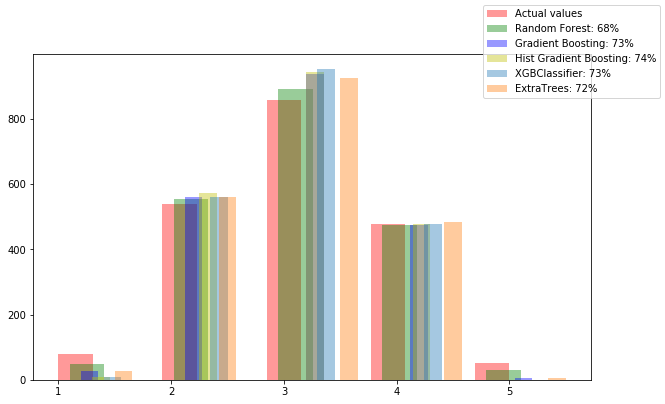

In [255]:
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.distplot(y_test,hist=True,kde = False,color="r")
sns.distplot(y_forest,hist=True,kde = False,color='g')
sns.distplot(y_grad,hist=True,kde = False,color='b')
sns.distplot(y_hist,hist=True,kde = False,color='y')
sns.distplot(y_xgb,hist=True,kde = False)
sns.distplot(y_extra,hist=True,kde = False)
fig.legend(labels=['Actual values','Random Forest: 68%', 'Gradient Boosting: 73%','Hist Gradient Boosting: 74%',
                  'XGBClassifier: 73%','ExtraTrees: 72%'])

The previous graph shows us differents histograms of models comparing to actual values of the Score variable, we can observe that all classifiers **don't perfom well on predicting the classes 1 and 5**.

Let's have a look separatly of this two values **(1 and 5)**.

In [289]:
def sns_plot(m):
    fig = plt.figure(figsize=(10,6))
    sns.distplot([val for val in y_test if val==m],hist=True,kde = False,color="r")
    sns.distplot([val for val in y_forest if val==m+n],hist=True,kde = False,color='g')
    sns.distplot([val for val in y_grad if val==m+2*n],hist=True,kde = False,color='b')
    sns.distplot([val for val in y_hist if val==m+3*n],hist=True,kde = False,color='y')
    sns.distplot([val for val in y_xgb if val==m+4*n],hist=True,kde = False)
    ax=sns.distplot([val for val in y_extra if val==m+5*n],hist=True,kde = False)
    ax.set_title("Predictions of Classe: "+str(m)+" VS Actual Values")

    fig.legend(labels=['Actual values','Random Forest', 'Gradient Boosting','Hist Gradient Boosting',
                      'XGBClassifier','ExtraTrees'])


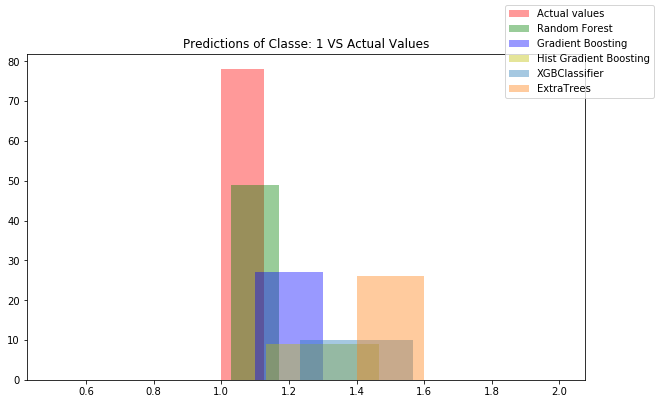

In [290]:
sns_plot(1)

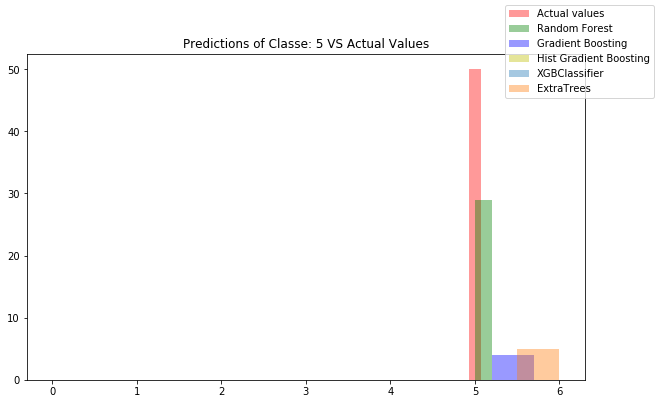

In [291]:
sns_plot(5)

By looking at the two previous graphs, we conclude obviously that all models perform very bad at the prediction of **the Score 
values 1 and 5,** perhaps it's due to **the low data dedicated for this two values.**

The submission on the website https://challengedata.ens.fr/participants/challenges/15/ gives an accuracy of **71.3%**

## Model Improvement
In this section, we will use the stacking technique of all previous classifiers to improve the accuracy on the website

In [293]:
models = [
    RandomForestClassifier(n_estimators=1000,max_depth=50, random_state=0,class_weight="balanced"),
    GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=0),
    HistGradientBoostingClassifier(max_iter=10,max_depth=10,random_state=0),
    xgb.XGBClassifier(objective="multi:softprob", random_state=0),
    ExtraTreesClassifier(n_estimators=500,max_depth=15, random_state=0)
]

In [294]:
data_test=pd.read_csv("x_test.csv")
x_sub=data_test.iloc[:, 2: 7].values

In [295]:
from sklearn.metrics import accuracy_score
S_train, S_test = stacking(models,                   
                           x_train, y_train, x_sub,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

task:         [classification]
n_classes:    [5]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [RandomForestClassifier]
    fold  0:  [0.67821452]
    fold  1:  [0.68000000]
    fold  2:  [0.69066667]
    fold  3:  [0.68645764]
    ----
    MEAN:     [0.68383471] + [0.00499617]
    FULL:     [0.68383333]

model  1:     [GradientBoostingClassifier]
    fold  0:  [0.72018654]
    fold  1:  [0.70400000]
    fold  2:  [0.73133333]
    fold  3:  [0.72915277]
    ----
    MEAN:     [0.72116816] + [0.01075632]
    FULL:     [0.72116667]

model  2:     [HistGradientBoostingClassifier]
    fold  0:  [0.73151233]
    fold  1:  [0.72000000]
    fold  2:  [0.74266667]
    fold  3:  [0.74182789]
    ----
    MEAN:     [0.73400172] + [0.00920021]
    FULL:     [0.73400000]

model  3:     [XGBClassifier]
    fold  0:  [0.72618254]
    fold  1:  [0.71266667]
    fold  2:  [0.74000000]
    fold  3:  [0.73849233]
    ----
    MEAN:     [0.72933538] + [0.011

In [296]:
hist_boost = HistGradientBoostingClassifier(max_iter=10,max_depth=10).fit(S_train, y_train)

In [300]:
y_pred0=hist_boost.predict(S_test)

We save the predicted values in a **cvs file** as required by the challenge

In [302]:
results = pd.DataFrame(columns = ['ID','Score'])
    # Kaggle veut que la colonne index commence par 1461
results['ID']=data_test['ID']
results['Score'] = y_pred0

    # écrire le resultats dans le fichier csv
results.to_csv('first.csv', index = False)

The accuracy was imporved on the website to **72.8%**